# Crossmodal project: Figure 2

In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import cmocean
import sys
sys.path.append(os.getcwd()+'\\..')

from utils import utils
import utils2
import plotting_utils as pu
import matplotlib.patches as patches
from matplotlib import gridspec
from tqdm import tnrange
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
importlib.reload(utils);
importlib.reload(pu);

## If exporting figures for adobe illustrator

In [3]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6)
mpl.rc('axes', labelsize=6)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## If plotting for inline visualization

In [4]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=16)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Load and process main data file that was exported from matlab. 
## Filter out high motion trials.

In [5]:
# unit_key_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\crossmodal\Figure2\z_scored_df.h5', 'table')
# log_df = pd.read_hdf(r'C:\Users\efink\Documents\Github\crossmodal\Figure2\log_df_processed.h5', 'table')
# log_df.drop_diplicates

In [6]:
data_directory = r'C:\Users\efink\Documents\DATA\Crossmodal_only'
log_df, unit_key_df = utils.load_data(data_directory)

In [7]:
bin_size = 0.025 ## will be used for many calculations below!!
log_df['mouse_name'].unique()

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
       'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0091', 'EF0099',
       'EF0101', 'EF0102', 'EF0111', 'EF0112', 'EF0114'], dtype=object)

In [8]:
subset_dict = utils.chunk_trials(log_df)
gen = (n for n in range(100))

unidentified


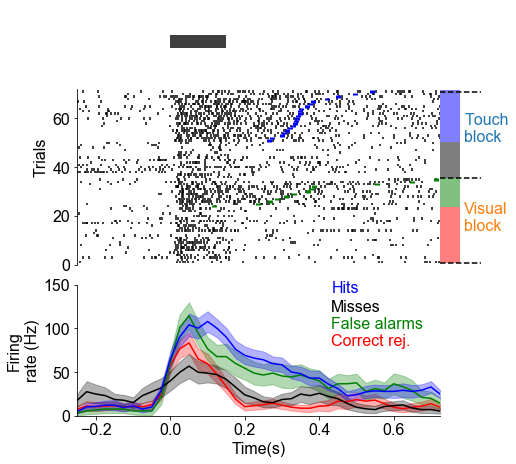

In [9]:
mpl.close('all')
fig2a_1 = utils.plot_unit(subset_dict, 'EF0079', 166, -0.25, 0.75, modality = 'Touch', ylim = (0,150), bin_size = bin_size)
fig2a_1.set_size_inches(8,7)

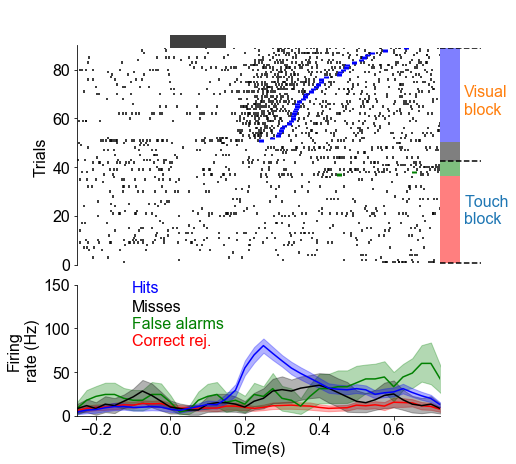

In [10]:
fig2a_2 = utils.plot_unit(subset_dict, 'EF0079', 166, -0.25, 0.75, modality = 'Visual', ylim = (0,150),bin_size = bin_size)
fig2a_2.set_size_inches(8,7)

In [11]:
# fig2a_1.savefig('fig2a_1.pdf',format='pdf', dpi = 900, transparent = True)
# fig2a_2.savefig('fig2a_2.pdf',format='pdf', dpi = 900, transparent = True)

In [12]:
# fig2a_1.savefig('fig2a_1.png',format='png', dpi = 900, transparent = True)
# fig2a_2.savefig('fig2a_2.png',format='png', dpi = 900, transparent = True)

In [13]:
mpl.close('all')

## Calculate Z-scores for each unit
#### determine baseline windows and calculate spike count histograms

In [14]:
# ITI is added on to the beginning of each trial therefore stim-onset time is a direct measure of ITI length.
# will restrict baseline periods to 0.5 s before stim onset - periods will be [-stimOnset to -0.5]
baseline_df = pd.DataFrame(-np.column_stack((log_df['stim_onset'], np.repeat(0.5, len(log_df['stim_onset'])))),
                  columns = ['baseline_min', 'baseline_max'])
log_df = pd.concat((log_df.reset_index(drop=True), baseline_df), axis=1)

# remove all trials with dropped stim-onsets that are due to premature licking
log_df['baseline_min'] = log_df['baseline_min'].replace(0, np.nan)
log_df = log_df.dropna(subset = ['baseline_min'])

# remove all trials with short ITIs and truncate ITIs of trials with ITIs longer than 3.5s
log_df = log_df.loc[log_df['baseline_min'] <= -3.5]  
log_df.loc[:, 'baseline_min'] = -3.5

edges = np.arange(-3.5, -1, bin_size)
log_df['baseline_spike_count'] = [np.histogram(trial_spikes, edges)[0] 
                                         for trial_spikes in log_df['spike_times(stim_aligned)']]

In [15]:
def unit_stats(uni_id):
    unit_rows = log_df[(log_df['uni_id'] == uni_id)]
    
    ## since there are 8 trial types (short/long x touchStim/visStim x touchBlock/visBlock) will use random sample of
    ## 1/8 of all trials to calculate mean and std of baseline firing rate for each unit
    baseline_trial_inds = rand.sample(list(unit_rows.index), int(np.max(unit_rows['trial_num'])/8))
    bin_means = np.mean(np.stack(unit_rows.loc[baseline_trial_inds, 
                                               'baseline_spike_count'].as_matrix(), axis = 0), axis=0)/bin_size
    unit_ind = np.where(unit_key_df['uni_id'] == uni_id)[0]
    unit_key_df.loc[unit_ind,'FR_mean'] = np.mean(bin_means)
    unit_key_df.loc[unit_ind,'FR_std'] = np.std(bin_means)
    
[unit_stats(unit_key_df.loc[x, 'uni_id']) for x in tnrange(len(unit_key_df['uni_id']))];

HBox(children=(IntProgress(value=0, max=2931), HTML(value='')))

### Calculate mean spike rate histograms for each trial type in order to use for Z-Score calculation
#### important: np.histogram counts all positive values from and including the start of the bin until but not including the start of the next bin

In [16]:
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

In [17]:
#%pdb
log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)
conds = ['Touch Stim Hit', 'Touch Stim CR', 'Touch Stim Miss','Touch Stim FA', 'Touch Stim FAr', 'Touch Stim FAl',
         'Visual Stim Hit','Visual Stim CR', 'Visual Stim Miss', 'Visual Stim FA', 'Visual Stim FAr', 'Visual Stim FAl']

z_conds = ['Touch Stim Hit(z_score)', 'Touch Stim CR(z_score)', 'Touch Stim Miss(z_score)', 'Touch Stim FA(z_score)',
           'Touch Stim FAr(z_score)', 'Touch Stim FAl(z_score)', 'Visual Stim Hit(z_score)','Visual Stim CR(z_score)',
           'Visual Stim Miss(z_score)', 'Visual Stim FA(z_score)', 'Visual Stim FAr(z_score)', 'Visual Stim FAl(z_score)']
for c in range(12):
    unit_key_df[conds[c]] = np.nan
    unit_key_df[conds[c]] = unit_key_df[conds[c]].astype(object)
    unit_key_df[z_conds[c]] = np.nan
    unit_key_df[z_conds[c]] = unit_key_df[z_conds[c]].astype(object)

#### Calculate Z-scores for each trial type for each unit

In [18]:
whisker = log_df['block_type'] == 'Whisker'
visual = log_df['block_type'] == 'Visual'
correct = log_df['correct'] == 1
lick = log_df['response'] != 0
lick_right = log_df['response'] == 1
lick_left = log_df['response'] == 2

t_stim = log_df['trial_type'].str.contains('Som')
v_stim = log_df['trial_type'].str.contains('Vis')

tt_key = pd.DataFrame()
tt_key['ts_hit'] = (t_stim  & whisker & correct)
tt_key['ts_cr'] = (t_stim & visual & correct)
tt_key['ts_fa'] = (t_stim & lick & ~correct)
tt_key['ts_miss'] = (t_stim & whisker & ~lick)
tt_key['vs_hit'] = (v_stim & visual & correct)
tt_key['vs_fa'] = (v_stim & lick & ~correct)
tt_key['vs_cr'] = (v_stim & whisker & correct)
tt_key['vs_miss'] = (v_stim & visual & ~lick)

tt_key['ts_fa_r'] = (t_stim & lick_right & ~correct)
tt_key['ts_fa_l'] = (t_stim & lick_left & ~correct)

tt_key['vs_fa_r'] = (v_stim & lick_right & ~correct)
tt_key['vs_fa_l'] = (v_stim & lick_left & ~correct)

tt_key.head(2)

,ts_hit,ts_cr,ts_fa,ts_miss,vs_hit,vs_fa,vs_cr,vs_miss,ts_fa_r,ts_fa_l,vs_fa_r,vs_fa_l
0,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False


In [19]:
def calc_zscore(ind):
    unit_key_id = unit_key_df.loc[ind, 'uni_id']
    unit_row_inds = log_df['uni_id'] == unit_key_df.loc[ind, 'uni_id']
    unit_rows = log_df[unit_row_inds]
    unit_tt = tt_key[unit_row_inds]
      
    trial_types = [unit_tt['ts_hit'],unit_tt['ts_cr'], unit_tt['ts_miss'], unit_tt['ts_fa'],
                   unit_tt['ts_fa_r'], unit_tt['ts_fa_l'], unit_tt['vs_hit'], unit_tt['vs_cr'],
                   unit_tt['vs_miss'], unit_tt['vs_fa'], unit_tt['vs_fa_r'], unit_tt['vs_fa_l']]
    bin_means_all = []
    for j in range(12):
        tt_rows = unit_rows[trial_types[j].as_matrix()]
        if len(tt_rows['spike_counts(stim_aligned)'].as_matrix())<1:
            bin_means = np.array([np.nan]*159)
        else:
            bin_means = np.mean(np.stack(tt_rows['spike_counts(stim_aligned)'].as_matrix(), axis = 0), axis=0)
            
        baseline_mean = unit_key_df.loc[ind, 'FR_mean']
        baseline_std = unit_key_df.loc[ind, 'FR_std']
        
        unit_key_df.set_value(ind,conds[j],bin_means)
        unit_key_df.set_value(ind,z_conds[j],(bin_means - baseline_mean)/baseline_std)

[calc_zscore(ind) for ind in tnrange(unit_key_df.shape[0])];

HBox(children=(IntProgress(value=0, max=2931), HTML(value='')))

C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [20]:
# log_df.to_hdf('log_df_processed.h5', 'table')
# unit_key_df.to_hdf('unit_key_df_processsed.h5', 'table')

In [21]:
act_resp_window = np.round(([0,.500] + np.abs(window[0]))/bin_size) -1

##need to do this in two parts otherwise python crashes
act_resp = unit_key_df.loc[:,z_conds].applymap(lambda y: y[int(act_resp_window[0]):int(act_resp_window[1])])
act_resp  = act_resp.applymap(lambda y: np.nanmean(y))

unit_key_df['activation_resp'] = act_resp['Touch Stim Hit(z_score)'] 

C:\Users\efink\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [22]:
#### !! 24 neurons were recorded in sessions where the mouse did not make any touch-FA - for presentation purposes I have 
#### removed the two sessions containing those neurons
sub_map = unit_key_df.sort_values(['activation_resp'], ascending = True)
z_scored_df = sub_map
# z_scored_df.to_hdf('z_scored_df.h5', 'table') 
no_FA_rows = (sub_map['Touch Stim FA'].apply(lambda x: all(np.isnan(x))) |
              sub_map['Visual Stim FA'].apply(lambda x: all(np.isnan(x))))
inf_rows = (sub_map['Touch Stim Hit(z_score)'].apply(lambda x: any(np.isinf(x))) |
            sub_map['Visual Stim Hit(z_score)'].apply(lambda x: any(np.isinf(x))))
sub_map = sub_map.loc[~no_FA_rows & ~inf_rows]

In [23]:
sub_map = sub_map[~(sub_map['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
sub_map['mouse_name'].unique()

array(['EF0077', 'EF0084', 'EF0079', 'EF0088', 'EF0081', 'EF0101',
       'EF0114', 'EF0089', 'EF0076', 'EF0074', 'EF0099', 'EF0102',
       'EF0091'], dtype=object)

<BarContainer object of 29 artists>

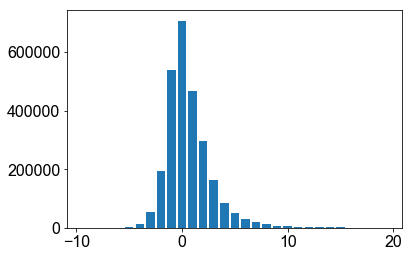

In [24]:
all_zvals = sub_map[['Touch Stim Hit(z_score)', 'Visual Stim FA(z_score)', 'Touch Stim Miss(z_score)','Visual Stim CR(z_score)',
                     'Touch Stim FA(z_score)', 'Visual Stim Hit(z_score)', 'Touch Stim CR(z_score)', 'Visual Stim Miss(z_score)']].values
all_zvals = np.concatenate(np.concatenate(all_zvals))
hist, xvals = np.histogram(all_zvals, bins = np.arange(-10, 20, 1), range = (-10, 20))
mpl.bar(xvals[1:], hist)

In [25]:
cont_grps = log_df[['mouse_name', 'contingency']].drop_duplicates().groupby('contingency')
sub_map2 = sub_map.merge(cont_grps.get_group('fwd'), on = 'mouse_name', how = 'inner').sort_values('activation_resp')
sub_map2['mouse_name'].unique()

array(['EF0077', 'EF0084', 'EF0079', 'EF0088', 'EF0081', 'EF0114',
       'EF0089', 'EF0076', 'EF0074'], dtype=object)

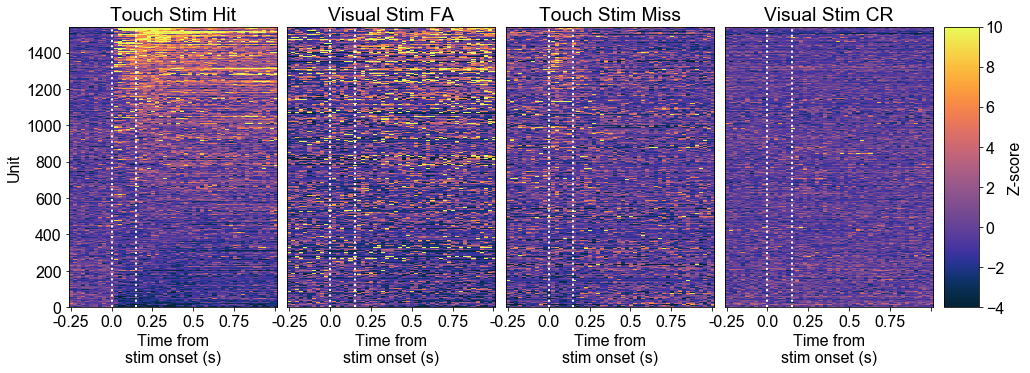

In [26]:
mpl.close('all')
columns = ['Touch Stim Hit(z_score)', 'Visual Stim FA(z_score)', 'Touch Stim Miss(z_score)','Visual Stim CR(z_score)']
data = {}
cmap = cmocean.cm.thermal
colors = cmap
for z_map in columns:
    data[z_map] = pd.DataFrame(np.stack(sub_map2[z_map].as_matrix()))
titles = ('Touch Stim Hit', 'Visual Stim FA', 'Touch Stim Miss','Visual Stim CR')
fig2b_supp1 = pu.create_heatmap(data, columns, colors, titles, [-0.25,1], [-4,10], 0.025)
fig2b_supp1.set_size_inches(16,5)
# fig2b_supp1.savefig('fig2b_fwdcontingency_heatmap.pdf', format = 'pdf', dpi = 900)

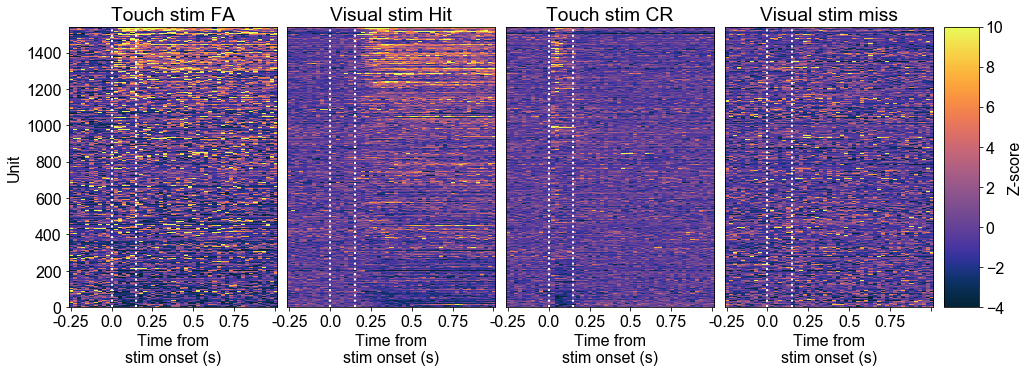

In [27]:
mpl.close('all')
# sub_map = unit_key_df.sort_values(['activation_resp'], ascending = True)
colors = cmocean.cm.thermal
columns = ['Touch Stim FA(z_score)', 'Visual Stim Hit(z_score)', 'Touch Stim CR(z_score)', 'Visual Stim Miss(z_score)']
data = {}

for z_map in columns:
    data[z_map] = pd.DataFrame(np.stack(sub_map2[z_map].as_matrix()))

titles = ('Touch stim FA','Visual stim Hit', 'Touch stim CR', 'Visual stim miss')
fig2b_2 = pu.create_heatmap(data, columns, colors, titles, [-0.25,1], [-4,10], 0.025)
fig2b_2.set_size_inches(16,5)

# fig2b_2.savefig('fig2b_fwdcontingency_heatmap2.pdf', format = 'pdf', dpi = 900)
# py.iplot(fig, filename= 'Hit_CR_Miss')

In [32]:
# fig2b_1.savefig('fig2b_1.pdf',format='pdf', dpi=900, transparent = True)
# fig2b_2.savefig('fig2b_2.pdf',format='pdf', dpi=900, transparent = True)

Text(0.5,0.98,'Touch lick-right/Visual lick-left')

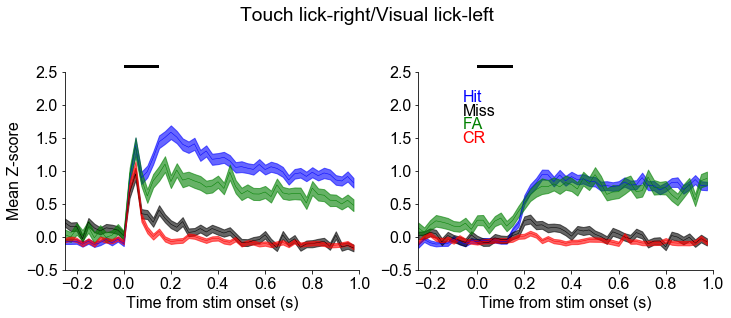

In [43]:
data = {}
columns = [['Touch Stim Hit(z_score)', 'Visual Stim Hit(z_score)'], ['Touch Stim Miss(z_score)', 'Visual Stim Miss(z_score)'],
 ['Touch Stim FA(z_score)', 'Visual Stim FA(z_score)'], ['Touch Stim CR(z_score)',  'Visual Stim CR(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.stack(sub_map2[z_map].as_matrix())) for z_map in col]


data = {}
columns = [['Touch Stim Hit(z_score)', 'Touch Stim Miss(z_score)', 
            'Touch Stim FA(z_score)','Touch Stim CR(z_score)'],
           ['Visual Stim Hit(z_score)','Visual Stim Miss(z_score)', 
            'Visual Stim FA(z_score)', 'Visual Stim CR(z_score)']]

for i,col in enumerate(columns):
    data[i] = [pd.DataFrame(np.stack(sub_map2[z_map].as_matrix())) for z_map in col]
    
importlib.reload(pu);
fig = pu.plot_zscore_psth(data, [-0.25, 1.01], bin_size, ['b', 'k', 'g', 'r'], labels = ['Hit', 'Miss', 'FA','CR'])
fig.set_size_inches(12,5)
fig.suptitle('Touch lick-right/Visual lick-left')
# fig.savefig('mean_zscore_psths_fwd.pdf',format='pdf', dpi=900, transparent = True)
